In [1]:
# Load Packages

# Some standard linear algebra stuff
using LinearAlgebra
using ExponentialUtilities
using SparseArrays

# For loading the dataset
using Downloads
using JLD2

# For visualization
using Printf
using LaTeXStrings
using CairoMakie
dark_latexfonts = merge(theme_black(), theme_latexfonts())
set_theme!(dark_latexfonts)

## Load vortex shedding data and visualize

In [2]:
n1 = Int(load("Cyl1.jld2", "n1"));    # number of grid points in horizontal direction
n2 = Int(load("Cyl1.jld2", "n2"));    # number of grid points in vertical direction
X1_1 = load("Cyl1.jld2", "X1_1");     # part 1 of horizontal velocity component
X1_2 = load("Cyl2.jld2", "X1_2");     # part 2 of horizontal velocity component
X2_1 = load("Cyl3.jld2", "X2_1");     # part 1 of vertical velocity component
X2_2 = load("Cyl4.jld2", "X2_2");     # part 2 of vertical velocity component

X1 = hcat(X1_1, X1_2);
X2 = hcat(X2_1, X2_2);

In [3]:
# calculate the absolute value of the velocity
XY = sqrt.(X1.^2 + X2.^2)

# spatial dimension and # of time steps
n = size(XY)[1]
m = size(XY)[2] - 1

# indices in the coordinate directions
p1 = 1:n1;
p2 = 1:n2;

# meshgrid
P2 = (p1' .* ones(n2))';
P1 = (ones(n1)' .* p2)';

# vectorize meshgrid such that the two coordinate 
# vectors have the same length as the XY[:, k]
P1v = vec(P1);
P2v = vec(P2);

# study the size of the system
println(@sprintf("# grid points in horizontal direction: %d", n1))
println(@sprintf("# grid points in vertical direction:   %d", n2))
println(@sprintf("# degrees of freedom in total:     n = %d", n))
println(@sprintf("# time steps:                      m = %d", m + 1))

# grid points in horizontal direction: 199
# grid points in vertical direction:   449
# degrees of freedom in total:     n = 89351
# time steps:                      m = 151


In [4]:
# Find indices for two sensor locations
function findIndex(p1,p2)
    ind = findmin((P1v .- p1).^2 + (P2v .- p2).^2)
    return Int(ind[2])
end;

# take only two measurements, located in the wake
i1 = findIndex(150.0, 100.0);
i2 = findIndex(200.0, 100.0);

In [5]:
# Function to normalize a vector to [0, 1]
# This is only used for plotting
function normalizeVector(x, lb = 0.35)
    dx = maximum(x) - minimum(x);
    return ((((x .- minimum(x)) ./ dx) .+ lb) ./ (1 + lb))
end;

# calculate indices for color range (for plotting)
Xcolor = normalizeVector(XY);

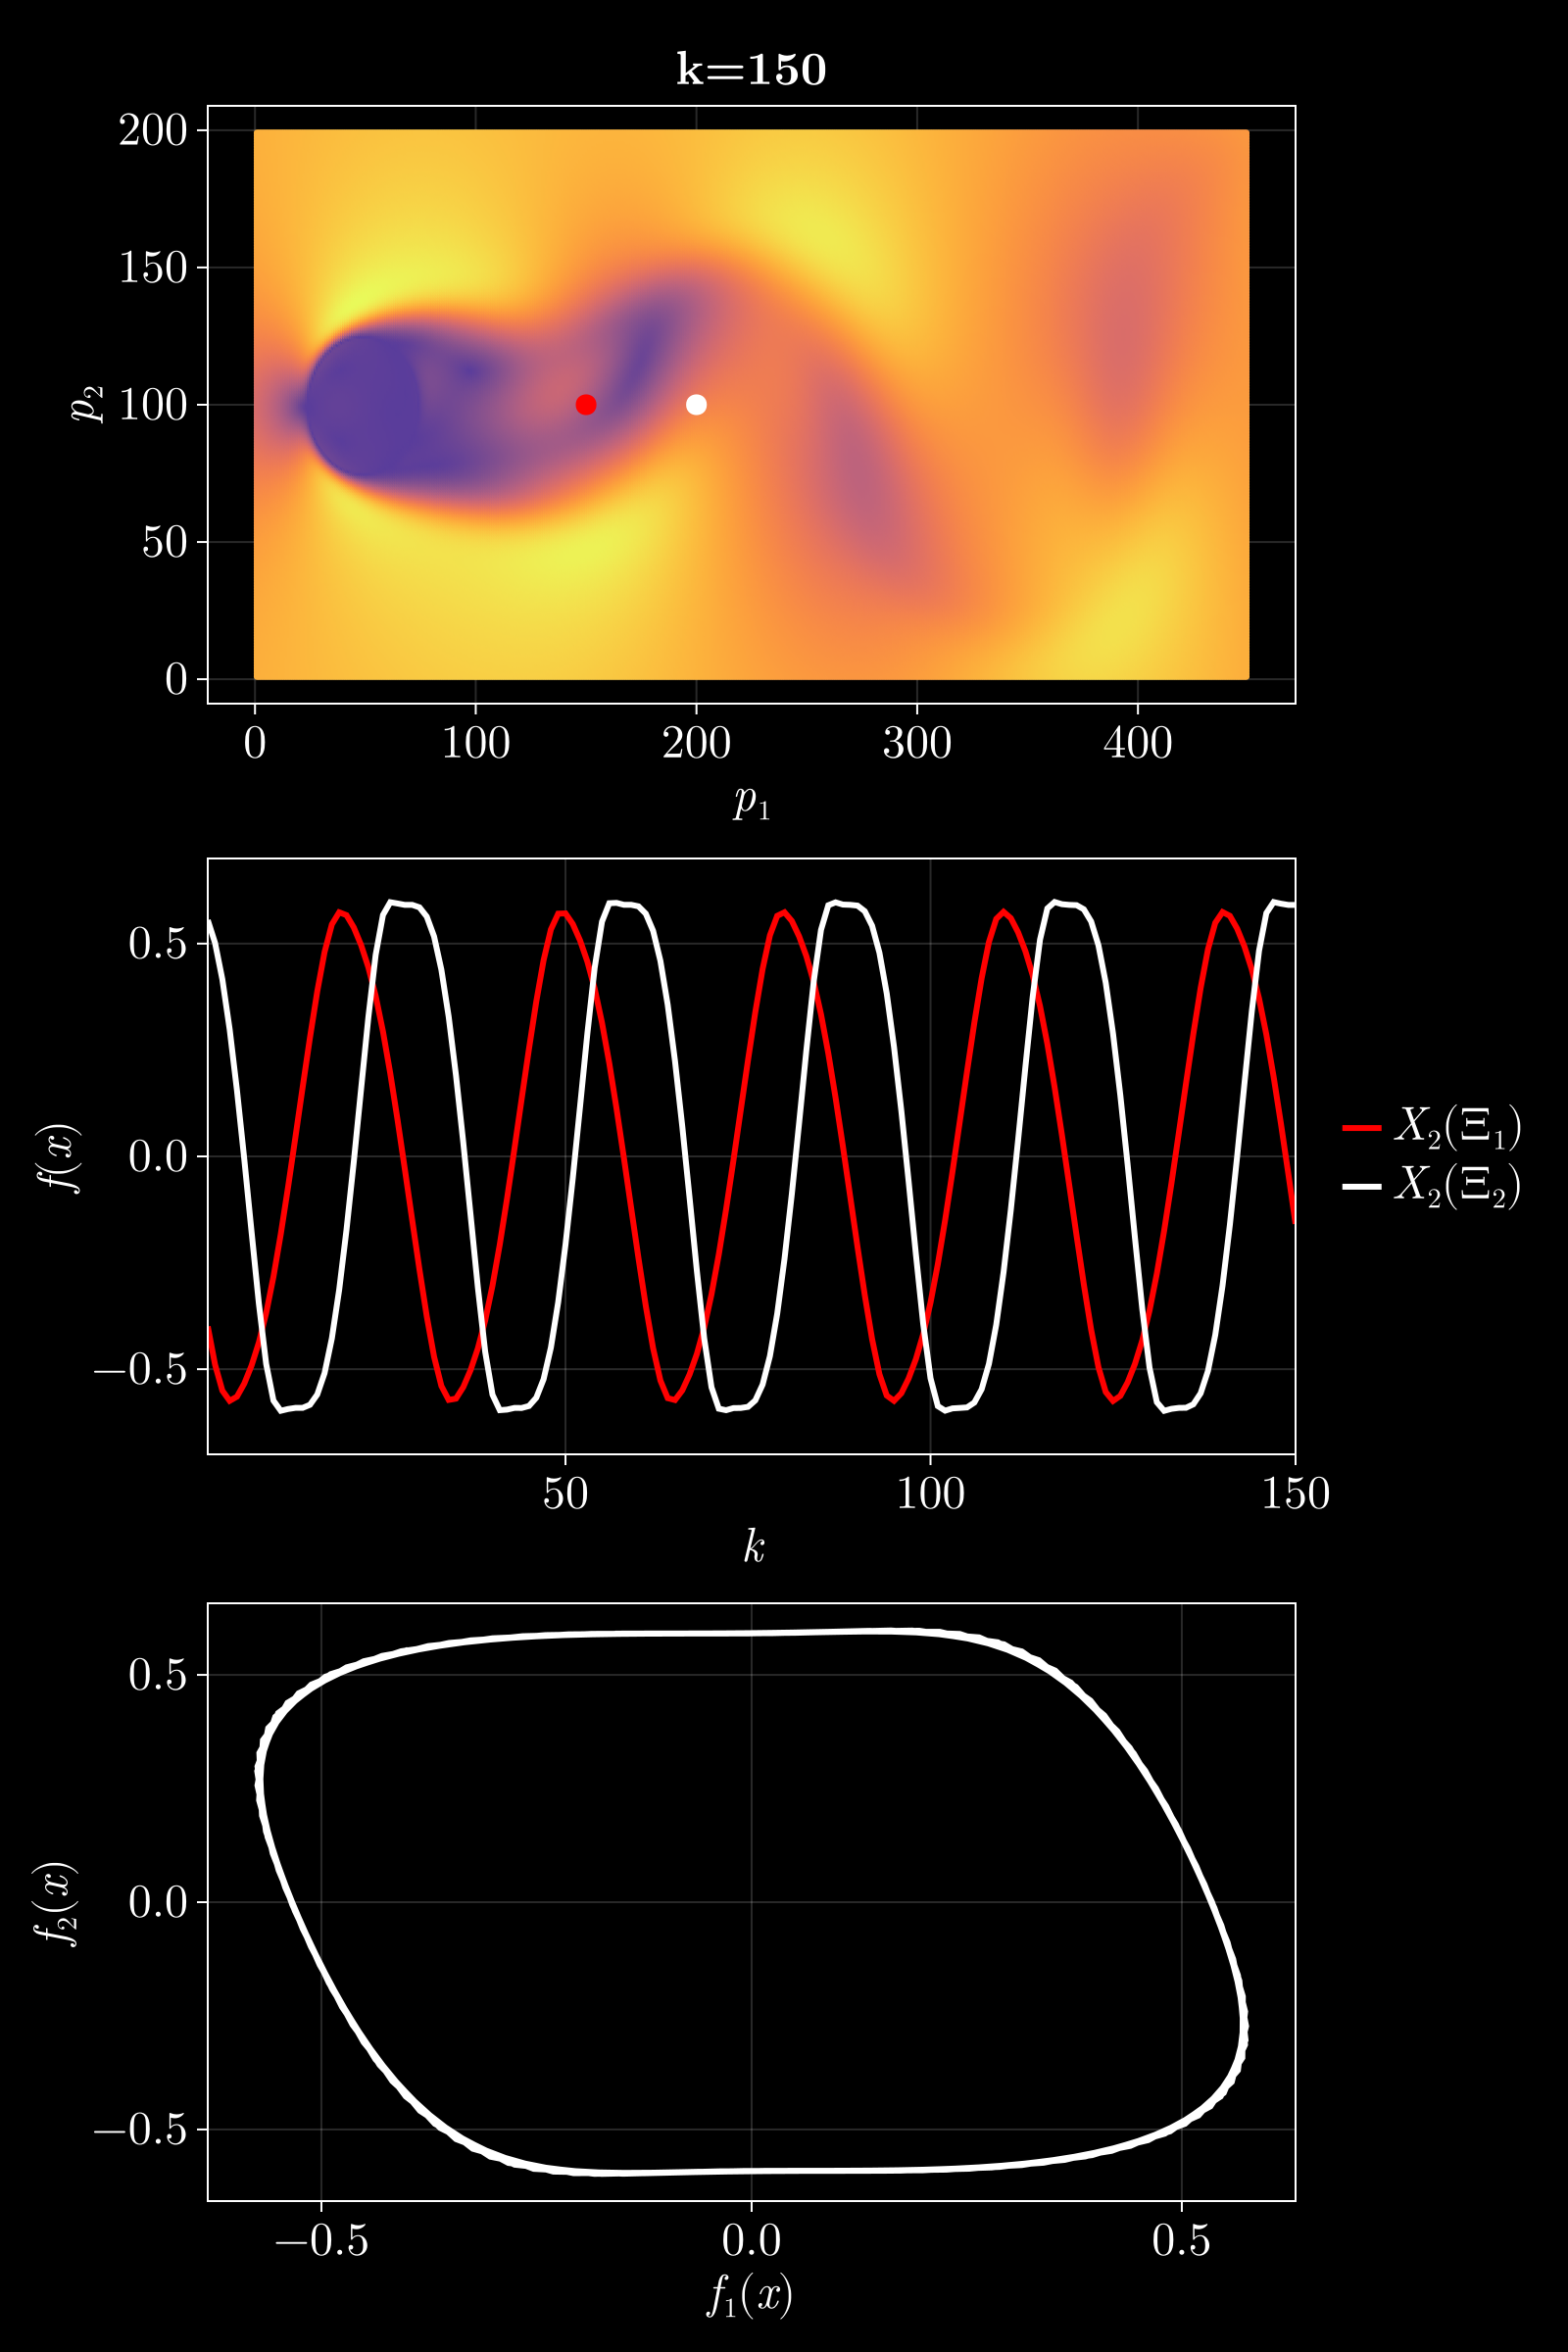

In [6]:
# Plotting
fig = Figure(fontsize = 24, size = (800, 1200), backgroundcolor = "black")
ax = Axis(fig[1, 1], backgroundcolor = "black", 
    title=@sprintf("k=%d", m), 
    xlabel=L"p_1", ylabel=L"p_2")
sc = scatter!(ax, P1v, P2v, color = Xcolor[:, 1], 
    colorrange = (0,1), markersize = 5, 
    colormap = :thermal)
sc2 = scatter!(ax, P1v[i1], P2v[i1], color = :red, 
    colorrange = (0,1), markersize = 15)
sc3 = scatter!(ax, P1v[i2], P2v[i2], color = :white, 
    colorrange = (0,1), markersize = 15)

ax2 = Axis(fig[2, 1], xlabel = L"k", ylabel = L"f(x)", limits=((1,m), (-0.7, 0.7)))
    lines!(ax2, 1:m, X2[i1, 1:m], linewidth=3, label=L"X_2(\Xi_1)", color=:red)
    lines!(ax2, 1:m, X2[i2, 1:m], linewidth=3, label=L"X_2(\Xi_2)", color=:white)
    fig[2, 2] = Legend(fig, ax2, framevisible = false)

ax3 = Axis(fig[3, 1], xlabel = L"f_1(x)", ylabel = L"f_2(x)")
    lines!(ax3, X2[i1, 1:m], X2[i2, 1:m], linewidth=3, label=L"X_2(\Xi_1)", color=:white)

fig

In [7]:
# Create video
# framerate = 12
# hue_iterator = range(1, m, length=m)

# fig = Figure(fontsize = 24, size = (800, 1200), backgroundcolor = "black")
# ax = Axis(fig[1, 1], backgroundcolor = "black", 
#     title=@sprintf("k=%d", 1), 
#     xlabel=L"p_1", ylabel=L"p_2")
# sc = scatter!(ax, P1v, P2v, color = Xcolor[:, 1], 
#     colorrange = (0,1), markersize = 5, 
#     colormap = :thermal)
# sc2 = scatter!(ax, P1v[i1], P2v[i1], color = :red, 
#     colorrange = (0,1), markersize = 15, 
#     colormap = :thermal)
# sc3 = scatter!(ax, P1v[i2], P2v[i2], color = :white, 
#     colorrange = (0,1), markersize = 15, 
#     colormap = :thermal)

# ax2 = Axis(fig[2, 1], xlabel = L"k", ylabel = L"f(x)", limits=((1,m), (-0.7, 0.7)))
#     lines!(ax2, 1:1, X2[i1, 1:1], linewidth=3, label=L"X_2(\Xi_1)", color=:red)
#     lines!(ax2, 1:1, X2[i2, 1:1], linewidth=3, label=L"X_2(\Xi_2)", color=:white)
# fig[2, 2] = Legend(fig, ax2, framevisible = false)

# ax3 = Axis(fig[3, 1], xlabel = L"f_1(x)", ylabel = L"f_2(x)", limits=((-0.7, 0.7), (-0.7, 0.7)))
#     sc4 = scatter!(ax3, X2[i1, 1:1], X2[i2, 1:1], markersize = 10, color=:white)

# record(fig, "Cylinder.mp4", hue_iterator;
#         framerate = framerate) do hue
#     sc.color = Xcolor[:, Int(hue)]
#     ax.title = @sprintf("k = %d", hue);

#     lines!(ax2, 1:Int(hue), X2[i1, 1:Int(hue)], linewidth=3, label=L"X_2(\Xi_1)", color=:red)
#     lines!(ax2, 1:Int(hue), X2[i2, 1:Int(hue)], linewidth=3, label=L"X_2(\Xi_2)", color=:white)
    
#     if hue > 1
#         scatter!(ax3, X2[i1, Int(hue - 1)], X2[i2, Int(hue - 1)], markersize = 10, color=:white)
#     end
#     scatter!(ax3, X2[i1, Int(hue)], X2[i2, Int(hue)], markersize = 10, color=:red)
    
# end;

## Dynamic Mode Decomposition

(89351, 150)
(150,)
(150, 150)


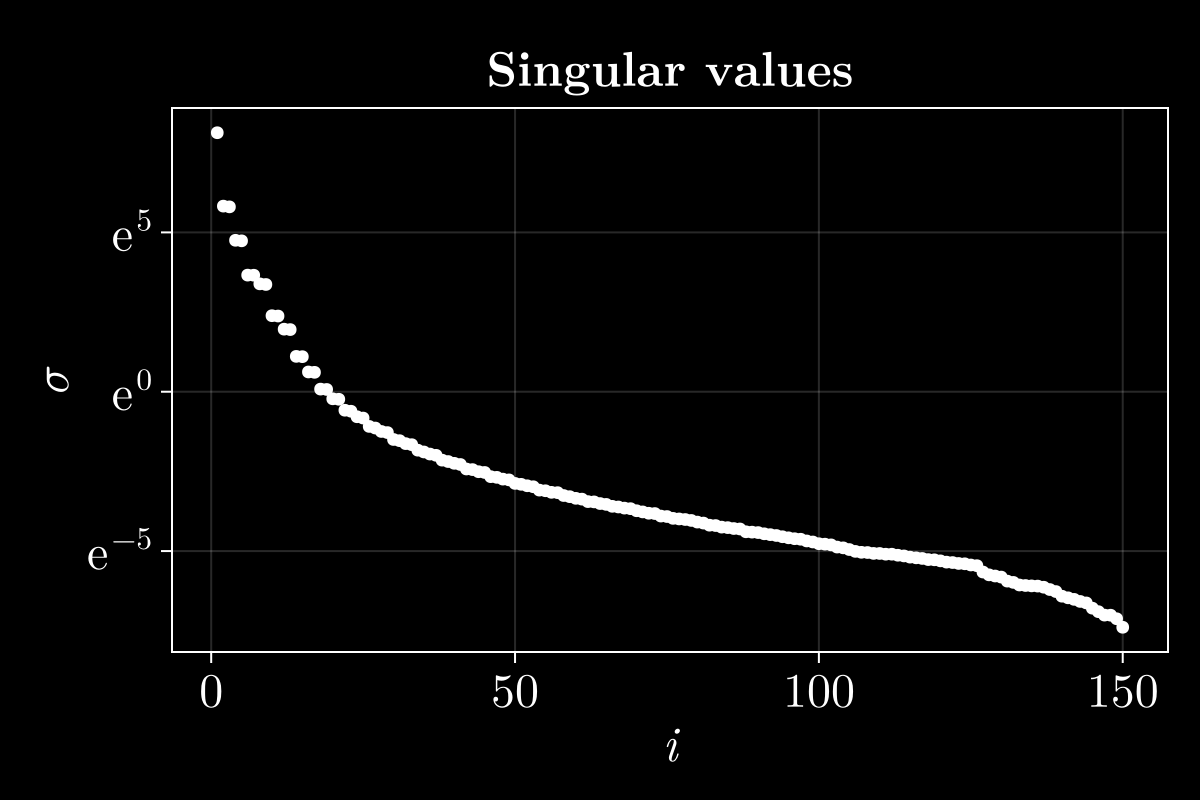

In [8]:
# Singular Value Decomposition (SVD) of the data
# (Julia automatically performs the economy version)
X = XY[:, 1 : end - 1]
Y = XY[:, 2 : end]

U, Σ, Q = svd(X);

println(size(U))
println(size(Σ))
println(size(Q'))

# Plot singular values
f = Figure(fontsize = 24, size = (600, 400), backgroundcolor = "black")
ax = Axis(f[1, 1], xlabel = L"i", ylabel = L"\sigma", yscale=log,
    title="Singular values")
scatter!(ax, range(1,length(Σ),length=length(Σ)), Σ, color="white")
f

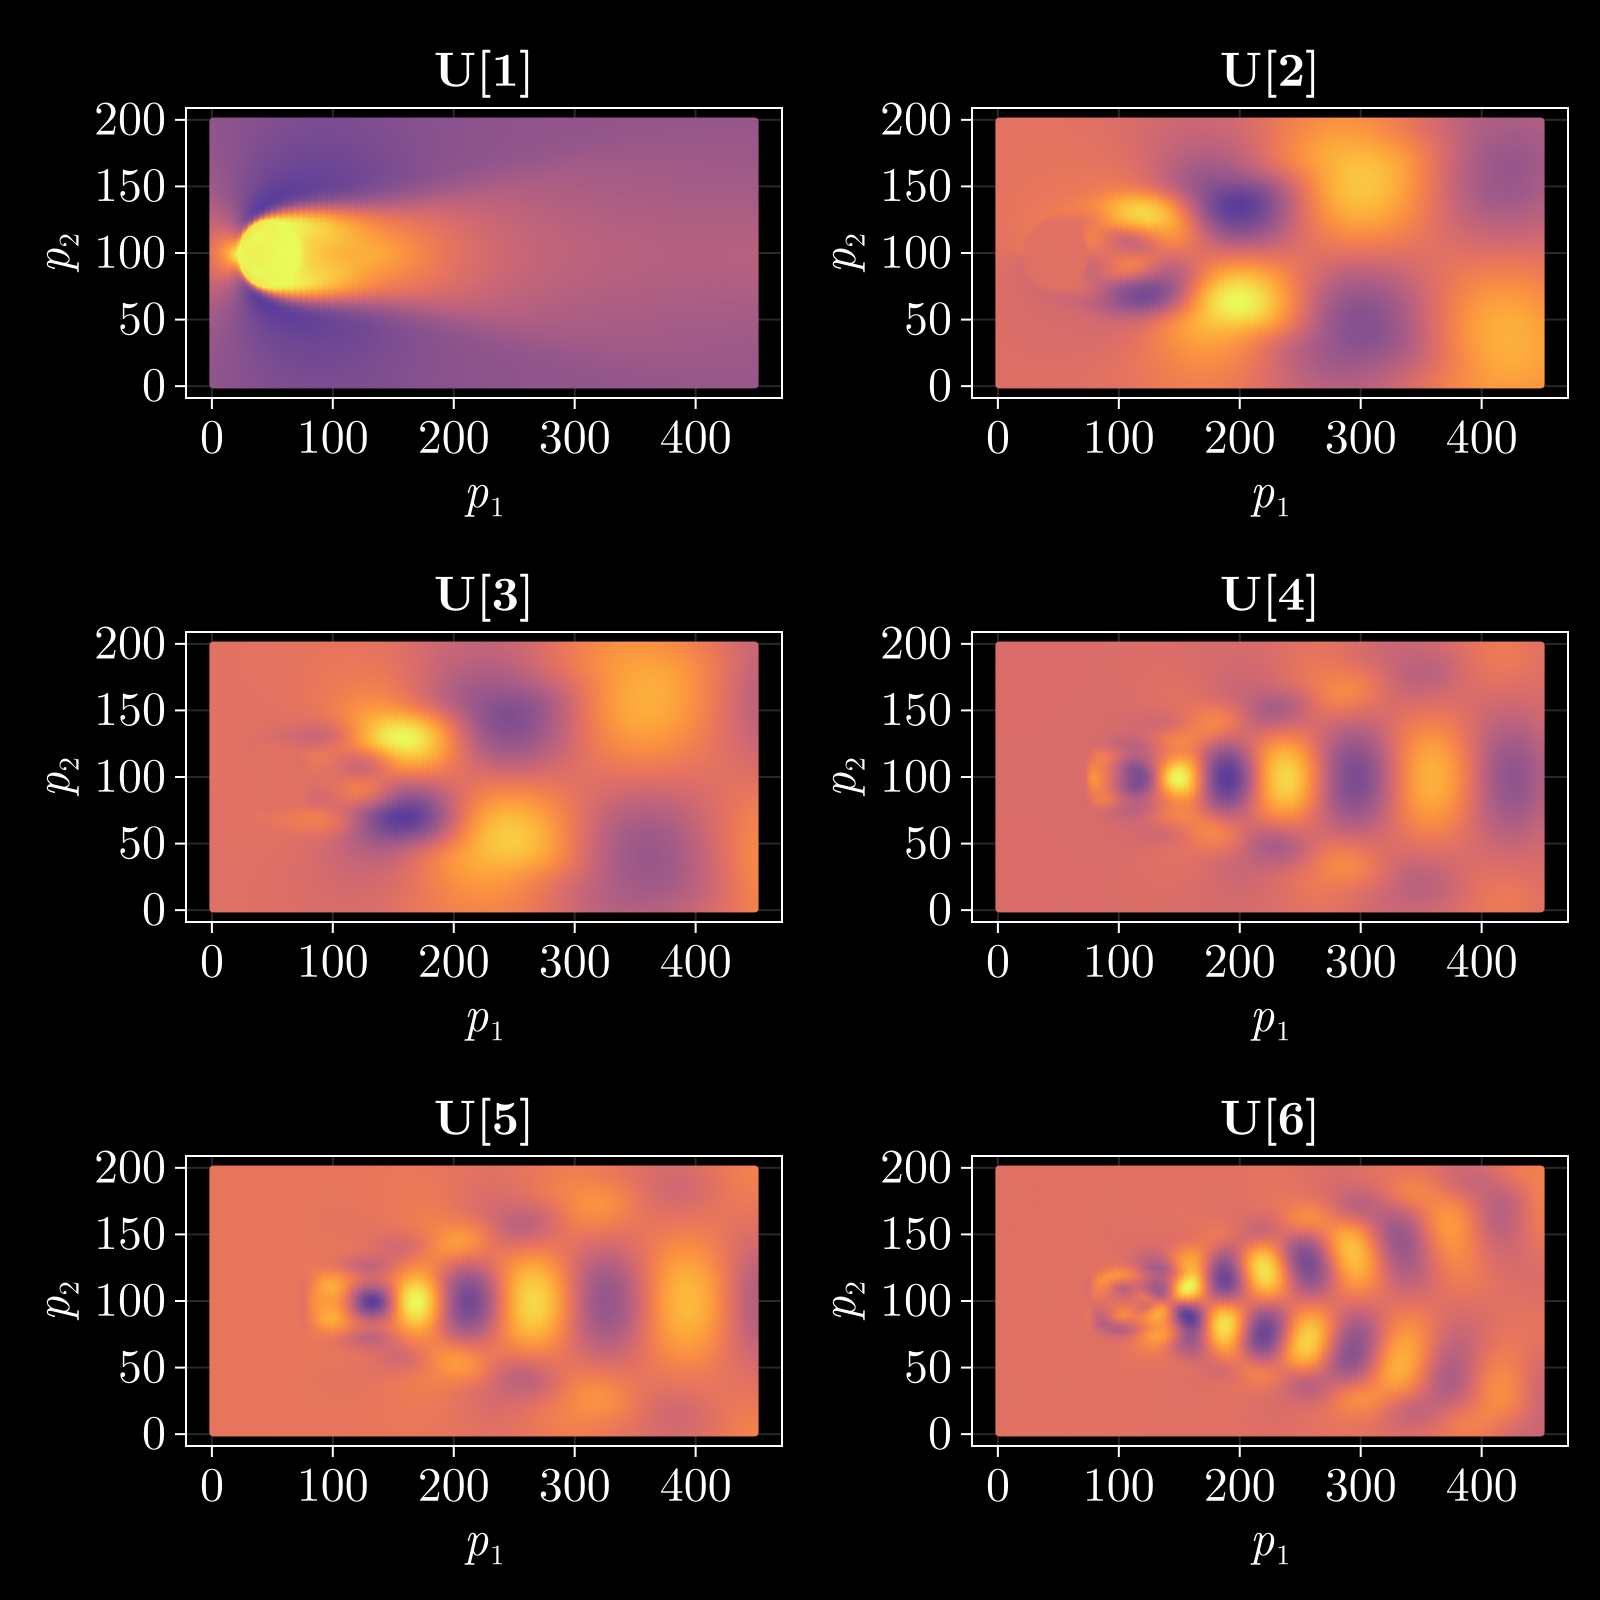

In [9]:
# Plot the singular vectors
fig = Figure(fontsize = 24, size = (800, 800), backgroundcolor = "black")
for i in 1 : 3
    for j in 1 : 2
        k = (i-1)*2 + j
        ax = Axis(fig[i, j], backgroundcolor = "black", 
            title=@sprintf("U[%d]", k), 
            xlabel=L"p_1", ylabel=L"p_2")
        sc = scatter!(ax, P1v, P2v, color = vec(normalizeVector(U[:, k])), 
            colorrange = (0,1), markersize = 5, 
            colormap = :thermal)
    end
end
fig

In [10]:
# rank of reduced matrix
r = 150;

# compute the reduced DMD matrix using the SVD matrices form before
A_tilde = U[:, 1 : r]' * Y * Q[:, 1 : r] * diagm( 1 ./ Σ[1 : r] );

# Eigenvalue problem in discrete-time
λ = eigvals(A_tilde);
P = eigvecs(A_tilde);

# Calculate the eigenvalues in continuous-time 
# λ = exp(μ · Δt) ⇔ μ = log(λ) / Δt (with Δt = 0.05)
μ = log.(λ) * 20

# Compute the frequency ω of the modes
# Recall: Imaginary part of the eigenvalue is 
# responsible for the oscillations:
# cos(ωt) + j · sin(ωt)
ω = imag.(μ)

# Sort according to ω
i_sort = sortperm(ω, by=abs)

ω = ω[i_sort]
λ = λ[i_sort]
P = P[:, i_sort]
μ = μ[i_sort]

# DMD modes
V = Y * Q[:, 1 : r] * diagm( 1 ./ Σ[1 : r] ) * P;

# average projection of flow field onto DMD modes
X_proj = vec((1/m) * ones((1,m)) * (abs.(X' * V[:, 1 : r])));

# sort the modes according to their importance:
i_dominant = reverse(sortperm(X_proj, by=abs));

# since the eigenvalues occur in complex conjugate pairs,
# we are going to visualize every other one
vals_to_plot = [i_dominant[1], i_dominant[3], i_dominant[5], i_dominant[7], i_dominant[9]];

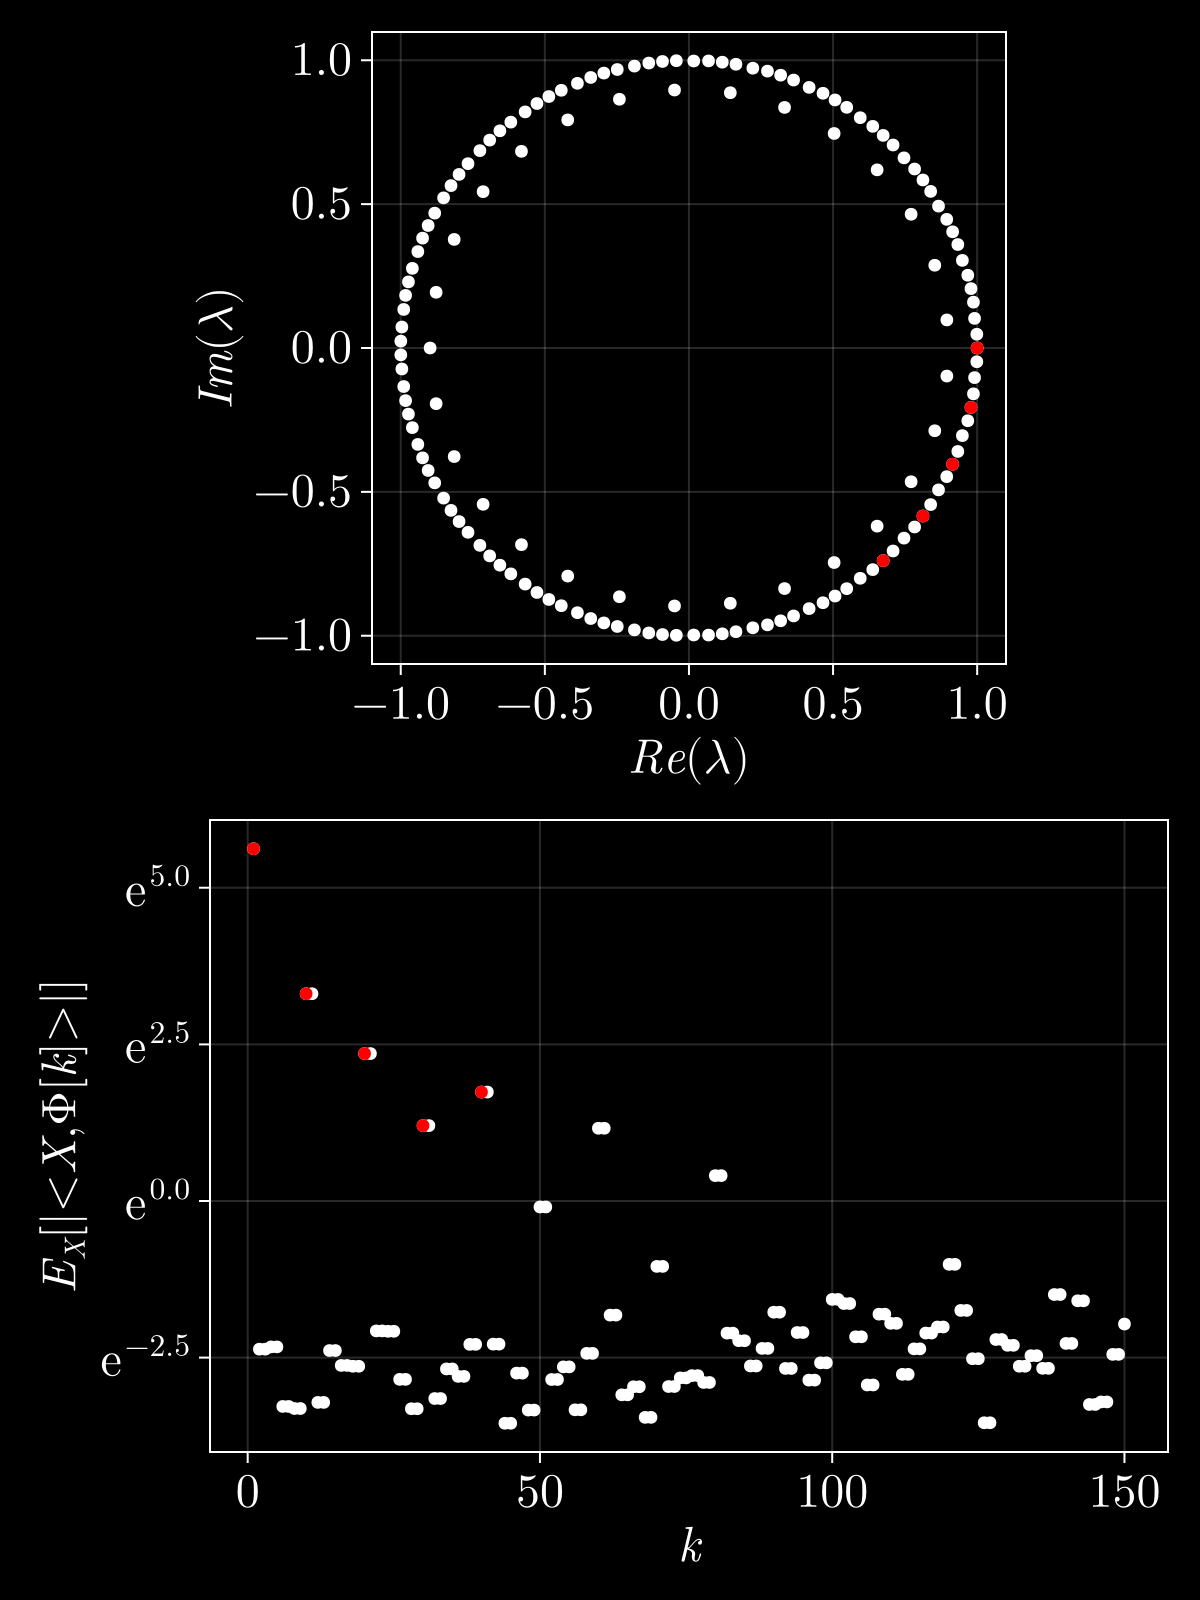

In [11]:
# Plot DMD eigenvalues and importance of modes (five most relevant in red)
f = Figure(fontsize = 24, size = (600, 800), backgroundcolor = "black")
ax = Axis(f[1, 1], xlabel = L"Re(λ)", ylabel = L"Im(λ)", aspect=DataAspect())
scatter!(ax, real(λ), imag(λ), color="white")
scatter!(ax, real(λ[vals_to_plot]), imag(λ[vals_to_plot]), color="red")
ax = Axis(f[2, 1], yscale=log, xlabel = L"k", ylabel = L"E_X[|<X, Φ[k]>|]")
scatter!(ax, range(1,r), X_proj, color="white")
scatter!(ax, vals_to_plot, X_proj[vals_to_plot], color="red")
f

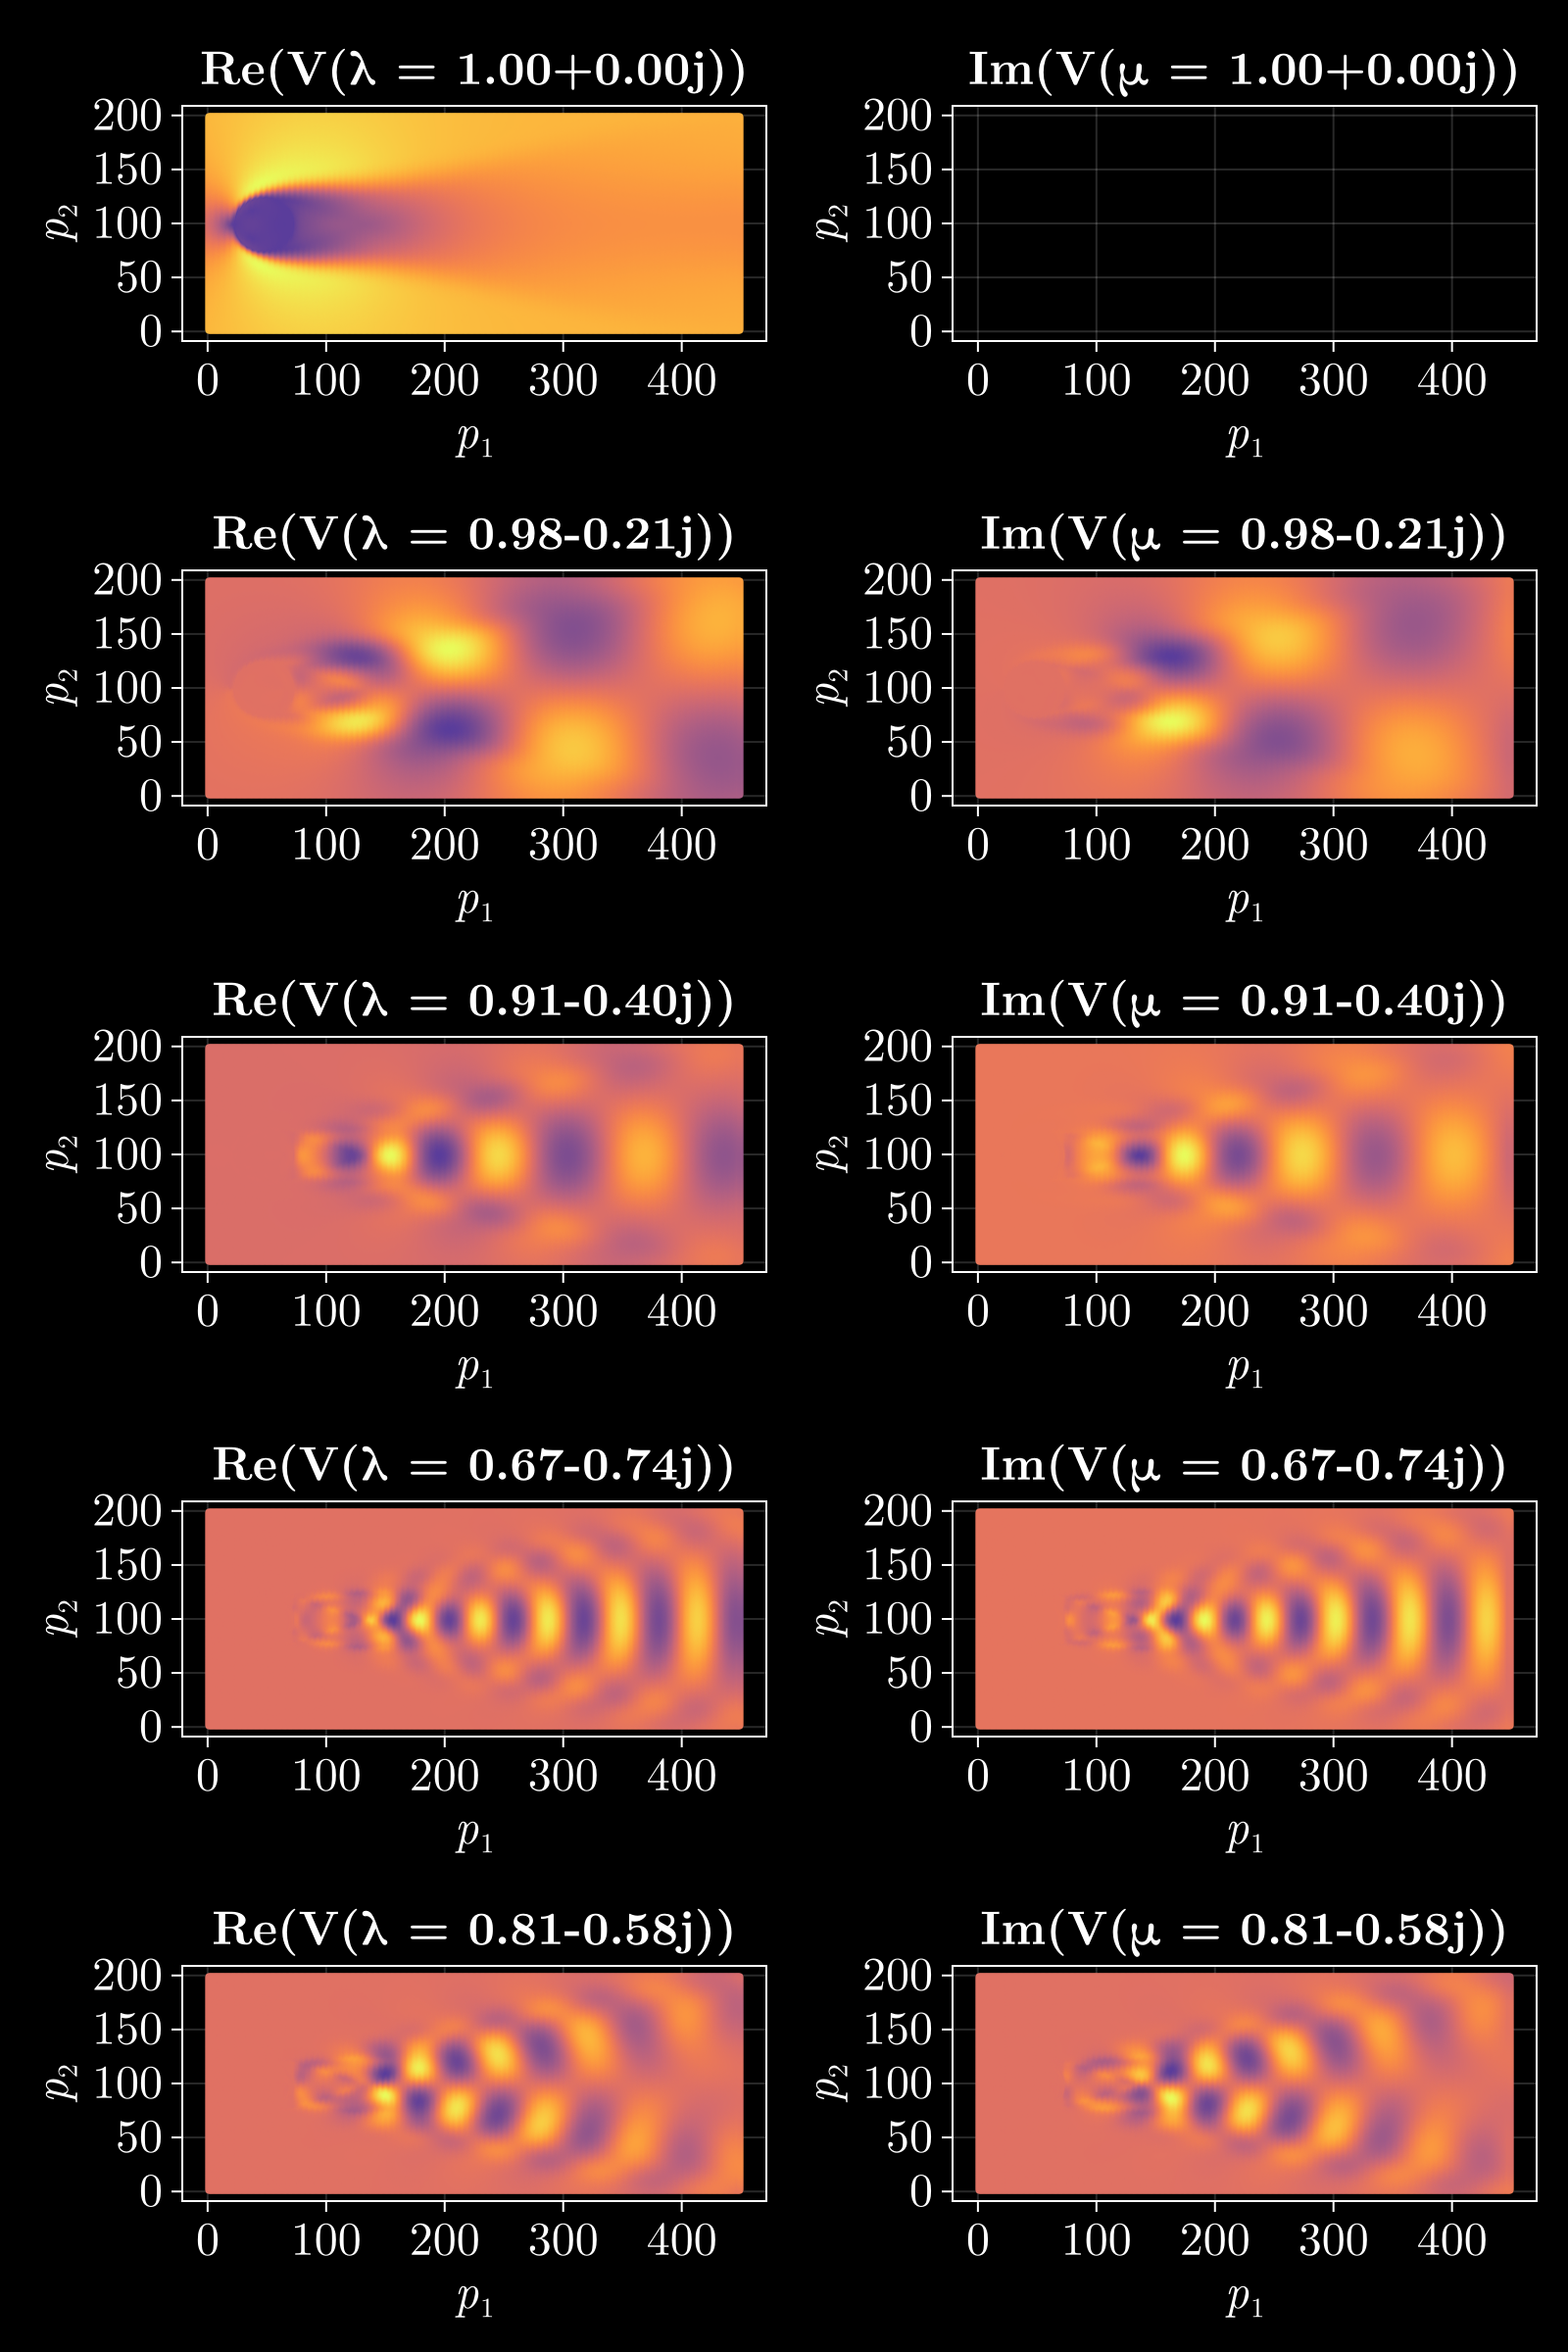

In [12]:
# visualization of selected DMD modes
fig = Figure(fontsize = 24, size = (800, 1200), backgroundcolor = "black")
for i in 1 : 5
    ax = Axis(fig[i, 1], backgroundcolor = "black", 
    title=@sprintf("Re(V(λ = %.2f%+.2fj))", real(λ[vals_to_plot[i]]), imag(λ[vals_to_plot[i]])), 
        xlabel=L"p_1", ylabel=L"p_2")

    sc = scatter!(ax, P1v, P2v, color = normalizeVector(real.(V[:, vals_to_plot[i]])), 
        colorrange = (0,1), markersize = 5, 
        colormap = :thermal)

    ax = Axis(fig[i, 2], backgroundcolor = "black", 
    title=@sprintf("Im(V(μ = %.2f%+.2fj))", real(λ[vals_to_plot[i]]), imag(λ[vals_to_plot[i]])), 
        xlabel=L"p_1", ylabel=L"p_2")

    sc = scatter!(ax, P1v, P2v, color = normalizeVector(imag.(V[:, vals_to_plot[i]])), 
        colorrange = (0,1), markersize = 5, 
        colormap = :thermal)
end
fig

## kernel EDMD

In [13]:
# polynomial kernel
d = 2;
ker(x,y) = (1 + dot(x,y))^d;

# calculate Ahat and Ghat
Ghat = zeros((m,m));
Ahat = zeros((m,m));
for i in 1 : m
    for j in 1 : m 
        Ghat[i,j] = ker(X[:, i], X[:, j])
        Ahat[i,j] = ker(X[:, i], Y[:, j])
    end
end

# Determine U and Σ from eigendecomposition
UΣ2 = eigen(Ghat);
U_kernel = UΣ2.vectors;
Σ_kernel = sqrt.(UΣ2.values);

# Sort by magnitude
i_sort = reverse(sortperm(Σ_kernel, by=abs));
U_kernel = U_kernel[:, i_sort];
Σ_kernel = diagm(Σ_kernel[i_sort]);

# Khat
Khat = (pinv(Σ_kernel) * U_kernel') * Ahat * (U_kernel * pinv(Σ_kernel));

In [14]:
# Determine Ξ and Λ from eigendecomposition
ξλ = eigen(Khat);
ξ_hat = ξλ.vectors;
λ_hat = ξλ.values;

# left eigenvectors
W_hat = eigvecs(Khat');

# Calculate the eigenvalues in continuous-time 
μ_hat = log.(λ_hat) * 20
ω_hat = imag.(μ_hat)

# Sort according to ω
i_sort = sortperm(ω_hat, by=abs)
ξ_hat = ξ_hat[:, i_sort]
λ_hat = λ_hat[i_sort]
W_hat = W_hat[:, i_sort]

# normalize vectors w* so that the inner product with ξ is 0
for i in 1 : m
    W_hat[:, i] /= dot(W_hat[:, i], ξ_hat[:, i])
end

# kernel DMD modes
ΦX = U_kernel * Σ_kernel * ξ_hat;

# Koopman modes
V_hat = (W_hat' * pinv(Σ_kernel) * U_kernel' * X')';


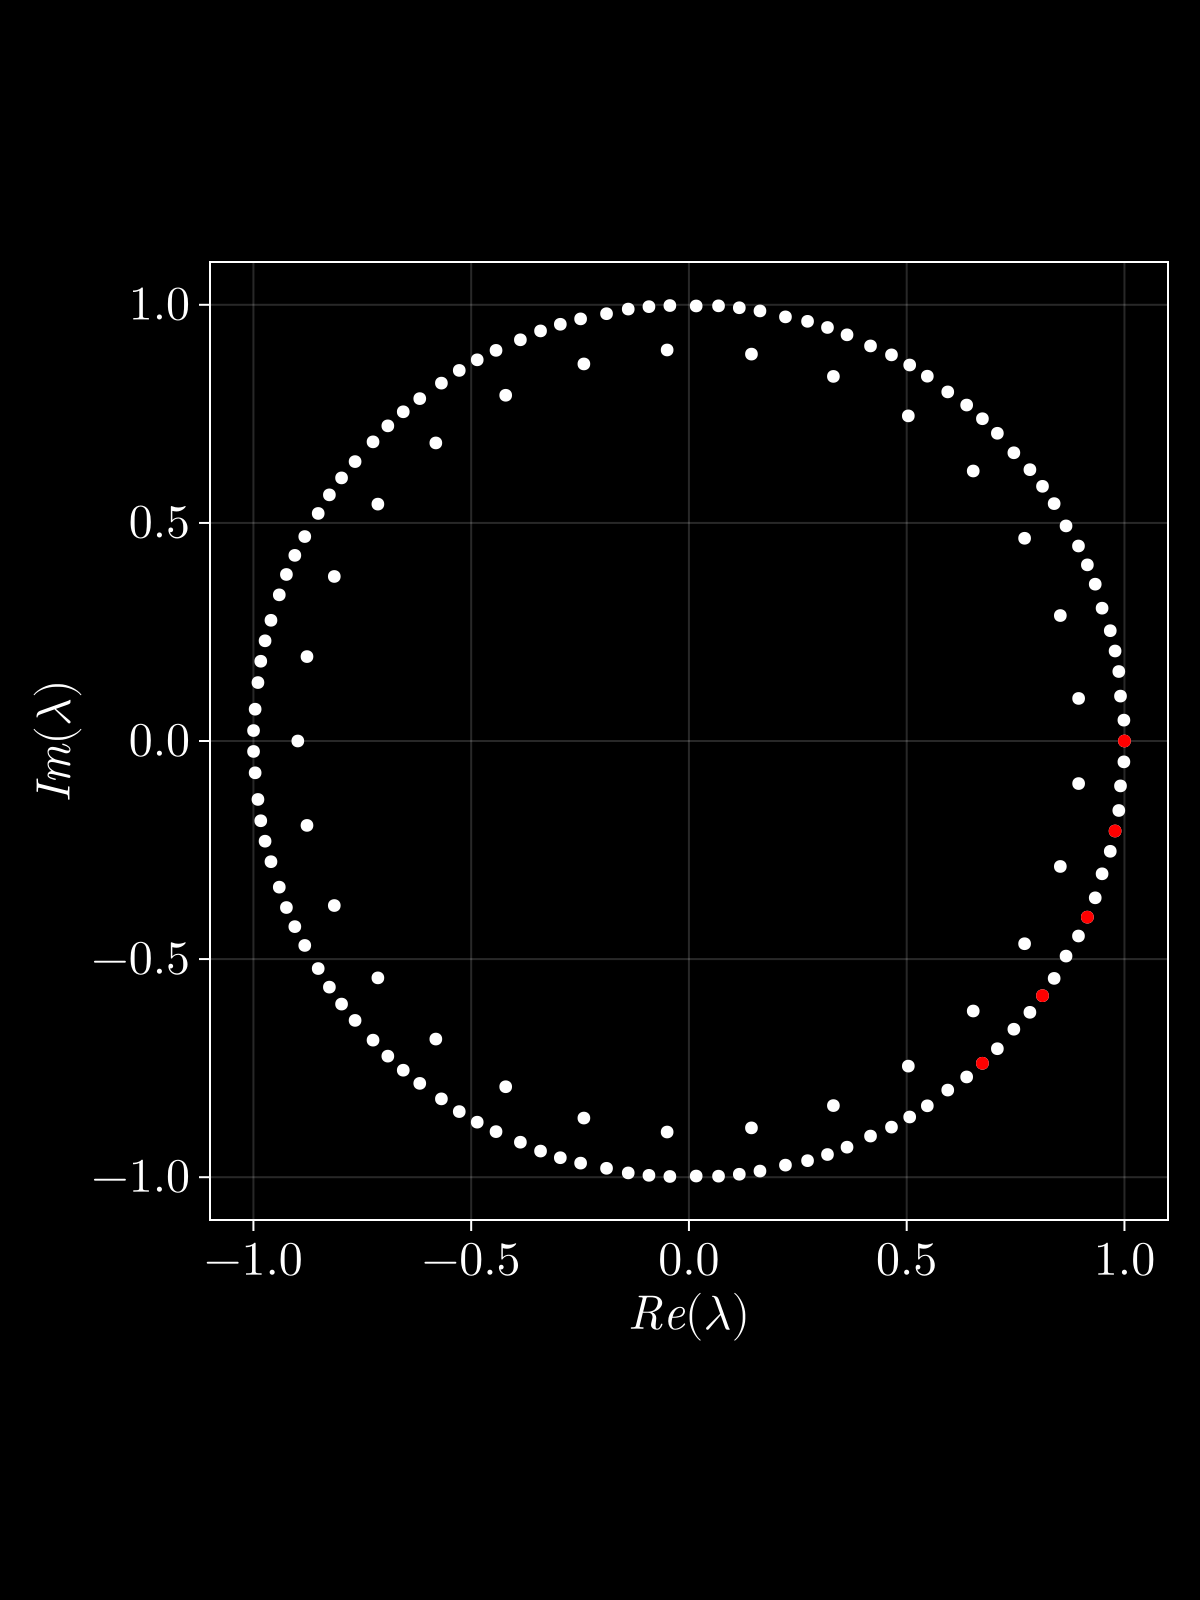

In [15]:
# Plot DMD eigenvalues and importance of modes (five most relevant in red)
f = Figure(fontsize = 24, size = (600, 800), backgroundcolor = "black")
ax = Axis(f[1, 1], xlabel = L"Re(λ)", ylabel = L"Im(λ)", aspect=DataAspect())
scatter!(ax, real(λ_hat), imag(λ_hat), color="white")
scatter!(ax, real(λ_hat[vals_to_plot]), imag(λ_hat[vals_to_plot]), color="red")
f

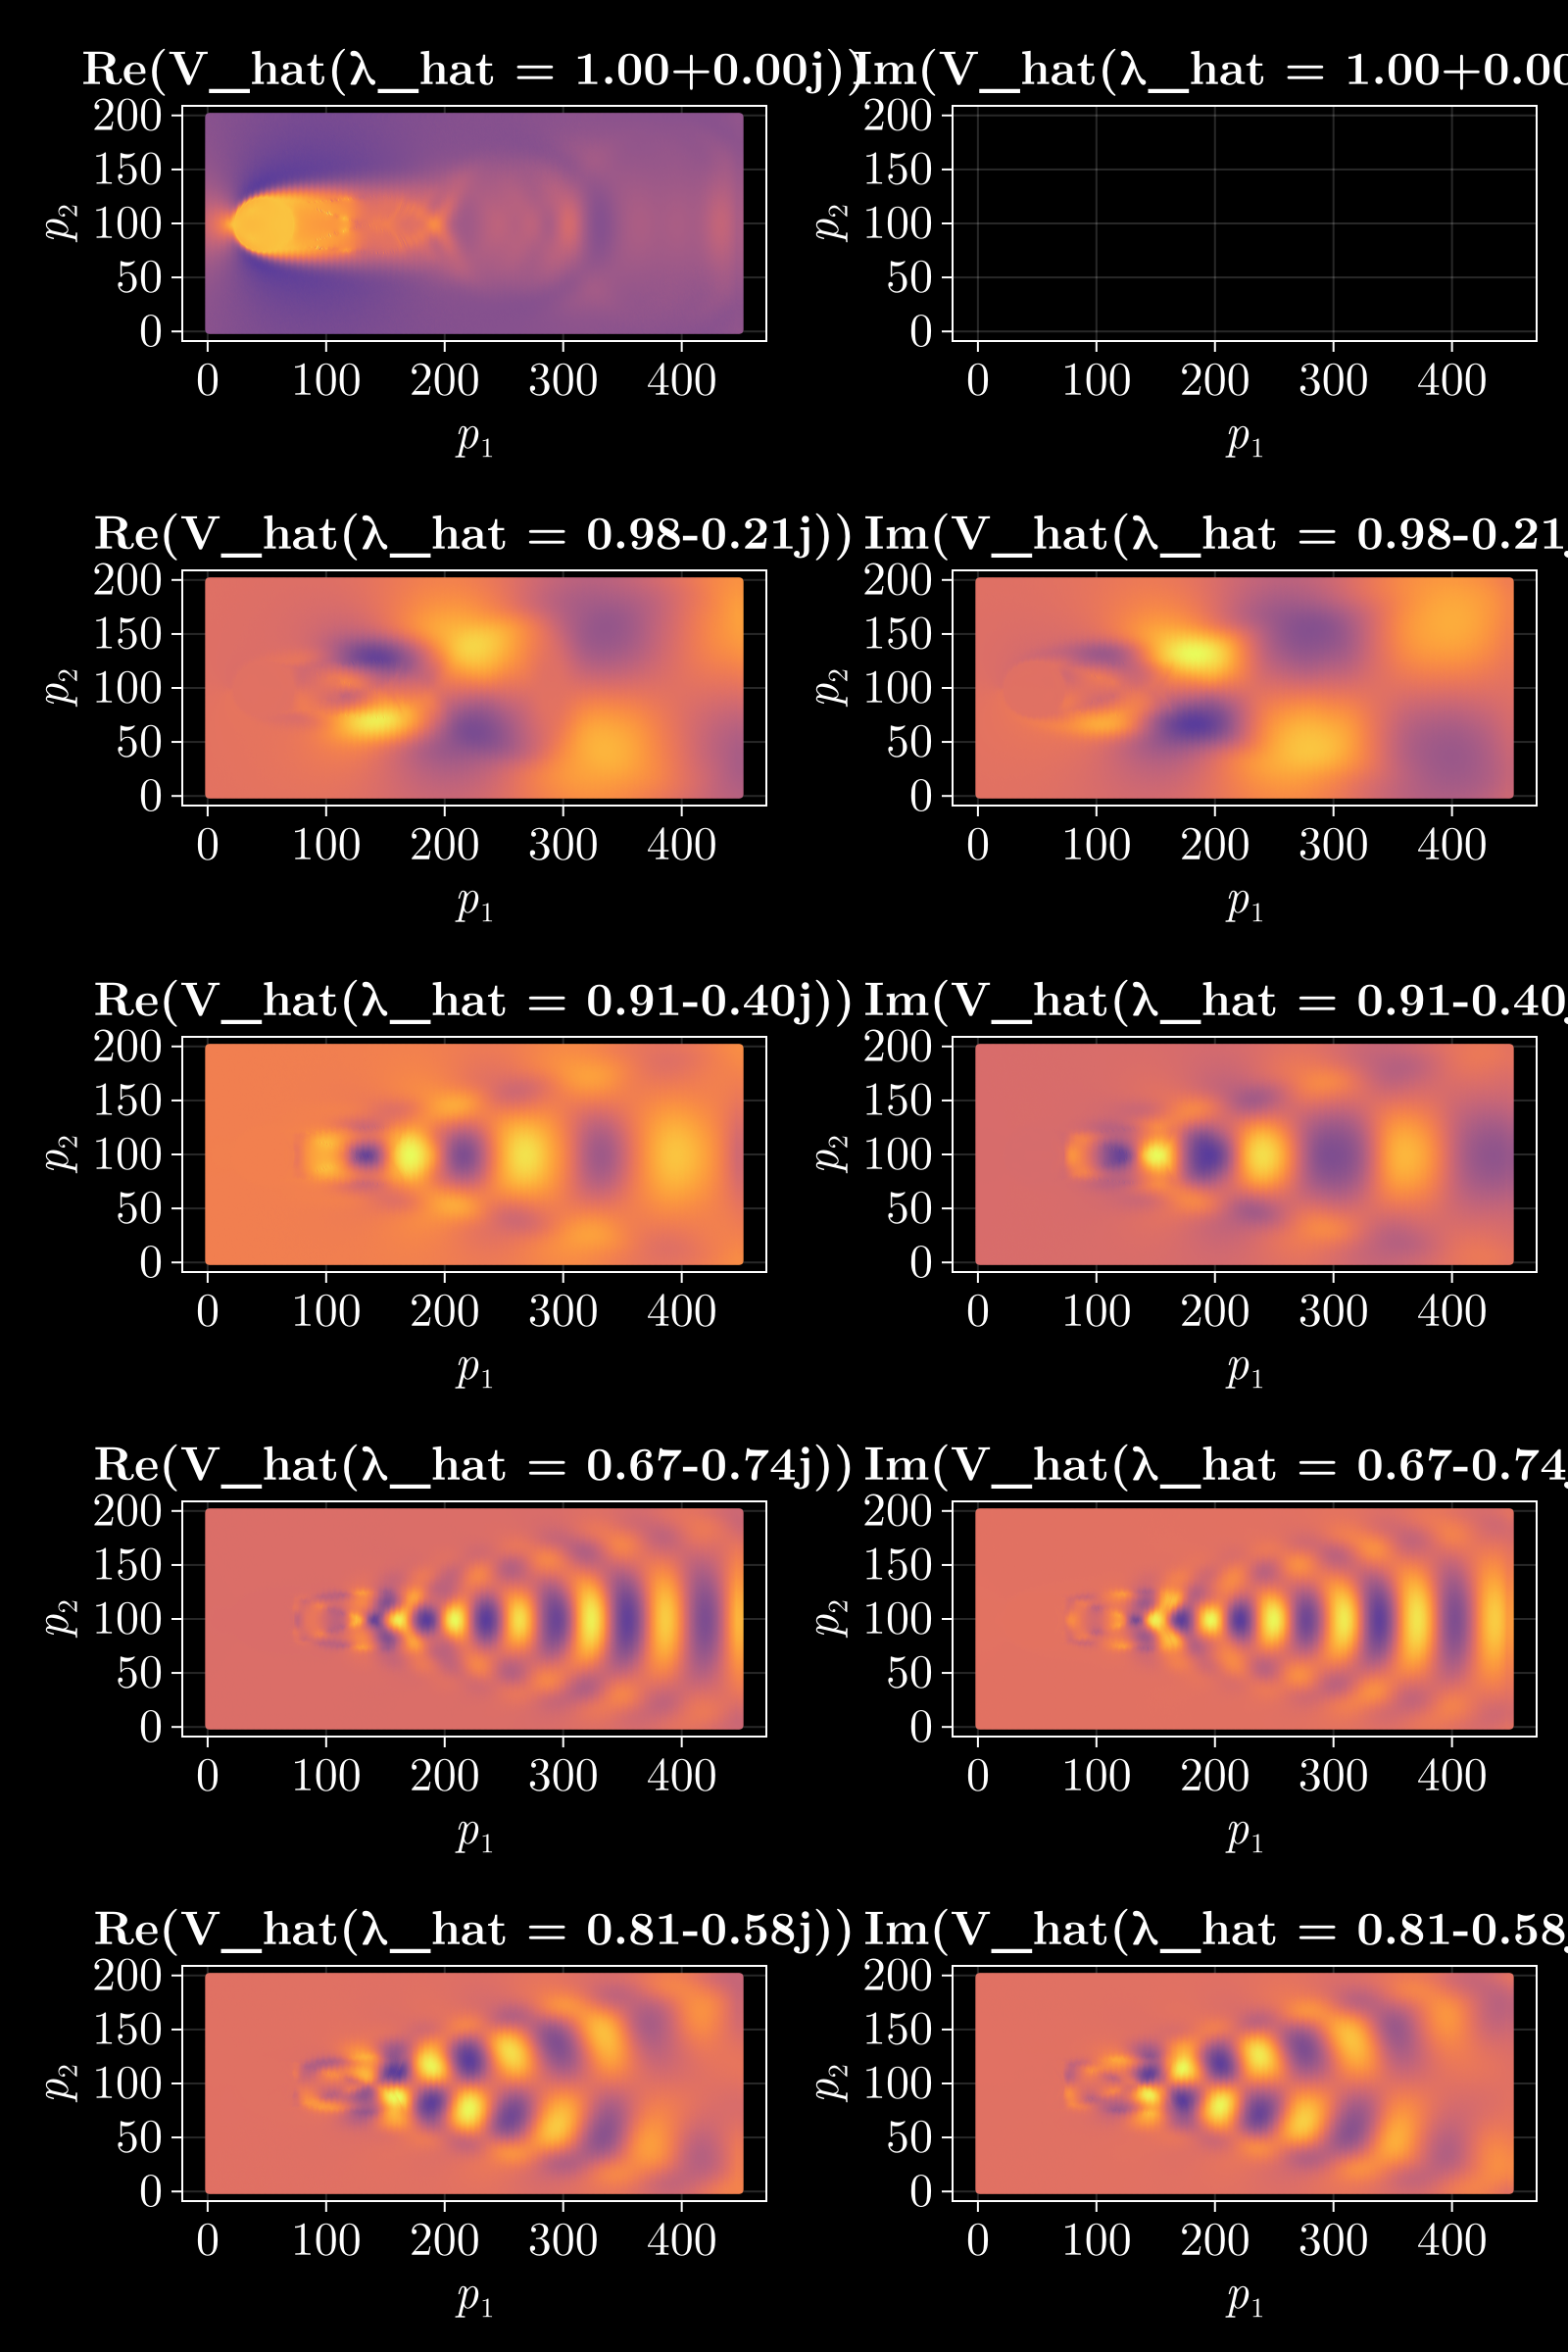

In [16]:
# visualization of selected kernel DMD modes
fig = Figure(fontsize = 24, size = (800, 1200), backgroundcolor = "black")
for i in 1 : 5
    ax = Axis(fig[i, 1], backgroundcolor = "black", 
    title=@sprintf("Re(V_hat(λ_hat = %.2f%+.2fj))", real(λ_hat[vals_to_plot[i]]), imag(λ_hat[vals_to_plot[i]])), 
        xlabel=L"p_1", ylabel=L"p_2")

    sc = scatter!(ax, P1v, P2v, color = normalizeVector(real.(V_hat[:, vals_to_plot[i]])), 
        colorrange = (0,1), markersize = 5, 
        colormap = :thermal)

    ax = Axis(fig[i, 2], backgroundcolor = "black", 
    title=@sprintf("Im(V_hat(λ_hat = %.2f%+.2fj))", real(λ_hat[vals_to_plot[i]]), imag(λ_hat[vals_to_plot[i]])), 
        xlabel=L"p_1", ylabel=L"p_2")

    sc = scatter!(ax, P1v, P2v, color = normalizeVector(imag.(V_hat[:, vals_to_plot[i]])), 
        colorrange = (0,1), markersize = 5, 
        colormap = :thermal)
end
fig